## Exploratory Data Analysis of Churn Dataset

Throgout this notebook we will explore the data and perform some initial analysis to understand the data and the problem. Based on this initial analysis we will select the features that we will use to train the model, along with the preprocessing steps we will apply to the data. The initial analysis is performed using ydata-profiling, a python library that helps to perform exploratory data analysis. Based on the initial analysis some graphs are generated to better understand the data and the problem. 

### Loading files and initial analysis

In [2]:
from pathlib import Path
import sys

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent  # sube al root real

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import RAW_TRAIN_PATH, RAW_TEST_PATH

sns.set_theme(style="whitegrid")

train_df = pd.read_csv(RAW_TRAIN_PATH)
test_df = pd.read_csv(RAW_TEST_PATH)

display(train_df.head())
display(test_df.head())

print(train_df.shape)
print(test_df.shape)


CustomerId    Surname  CreditScore  ... IsActiveMember EstimatedSalary  Exited
0    15759244      Boone        687.0  ...              1         1787.85       0
1    15725997        She        660.0  ...              0        19199.61       0
2    15724296       Kerr        684.0  ...              0       120284.67       0
3    15636820     Loggia        725.0  ...              0        62027.90       0
4    15744529  Chiekwugo        510.0  ...              1       115291.86       0

[5 rows x 13 columns]

CustomerId     Surname  ...  IsActiveMember EstimatedSalary
0    15764618       Tseng  ...               1        85167.88
1    15626385      George  ...               1        49672.01
2    15687413  Sunderland  ...               1       117616.29
3    15759067      Bromby  ...               1       117690.58
4    15614049          Hu  ...               1       139161.64

[5 rows x 12 columns]

(8000, 13)
(2000, 12)


### Bonus track - Exploratory Data Analysis using ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train_df, title="Bank Churn Dataset Profiling Report")
profile.to_notebook_iframe()
# profile.to_file("profile.json")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:01<00:00, 10.68it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Analysis Configuration & Data preparation for Visualization

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'

output_dir = "../docs/images"
os.makedirs(output_dir, exist_ok=True)
df_plot = train_df.copy()

df_plot['Status'] = df_plot['Exited'].map({0: 'Retenido', 1: 'Abandono'})

custom_palette = {"Retenido": "#3498db", "Abandono": "#e74c3c"}

### Dataset Statistics

In [16]:
print("Train data statistics")
display(train_df.describe())

Train data statistics


CustomerId  CreditScore  ...  EstimatedSalary      Exited
count  8.000000e+03  6359.000000  ...      7168.000000  8000.00000
mean   1.569119e+07   661.235257  ...    100057.165753     0.20375
std    7.187227e+04    95.876126  ...     57441.733108     0.40281
min    1.556570e+07   350.000000  ...        11.580000     0.00000
25%    1.562896e+07   595.000000  ...     51545.352500     0.00000
50%    1.569112e+07   664.000000  ...    100129.075000     0.00000
75%    1.575373e+07   729.000000  ...    149216.320000     0.00000
max    1.581569e+07   850.000000  ...    199992.480000     1.00000

[8 rows x 10 columns]

### Data quality overview

In [17]:
data_quality = (
    train_df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda df_: df_["missing_count"] / len(train_df))
    .sort_values("missing_pct", ascending=False)
)

display(data_quality)
print("Duplicate rows in train:", train_df.duplicated().sum())
print("Duplicate rows in test:", test_df.duplicated().sum())

missing_count  missing_pct
CreditScore               1641     0.205125
Balance                   1615     0.201875
NumOfProducts              976     0.122000
EstimatedSalary            832     0.104000
Surname                    409     0.051125
HasCrCard                  375     0.046875
Gender                       0     0.000000
CustomerId                   0     0.000000
Geography                    0     0.000000
Age                          0     0.000000
Tenure                       0     0.000000
IsActiveMember               0     0.000000
Exited                       0     0.000000

Duplicate rows in train: 0
Duplicate rows in test: 0


**Observations on Data Quality:**

- Several columns like `CreditScore`, `Balance`, `NumOfProducts`, `HasCrCard`, and `EstimatedSalary` have a significant number of missing values (around 10-20%). This will require an imputation strategy before training (e.g., using the mean, median, or a model-based imputer).
- There are no duplicate rows in the training or test sets, which is good.

### Target Analysis

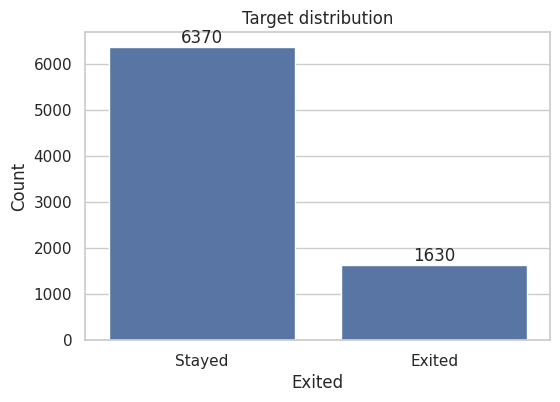

Exited
Stayed    6370
Exited    1630
Name: count, dtype: int64
Target rate: 0.20375


In [18]:
target_counts = train_df["Exited"].value_counts().rename(index={0: "Stayed", 1: "Exited"})
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, ax=ax)
ax.set_title("Target distribution")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()

print(target_counts)
print("Target rate:", target_counts.get("Exited", 0) / target_counts.sum())

**Observations on Target Distribution:**

- The dataset is imbalanced, with approximately 20% of customers having churned. 
- This imbalance is important to consider during modeling. We might need to use techniques like over-sampling (e.g., SMOTE), under-sampling, or use class weights in the models to prevent the model from being biased towards the majority class.

#### Age impact on Churn

/tmp/ipykernel_6519/3601488364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Gráfico guardado en: ../docs/images/01_boxplot_age.png


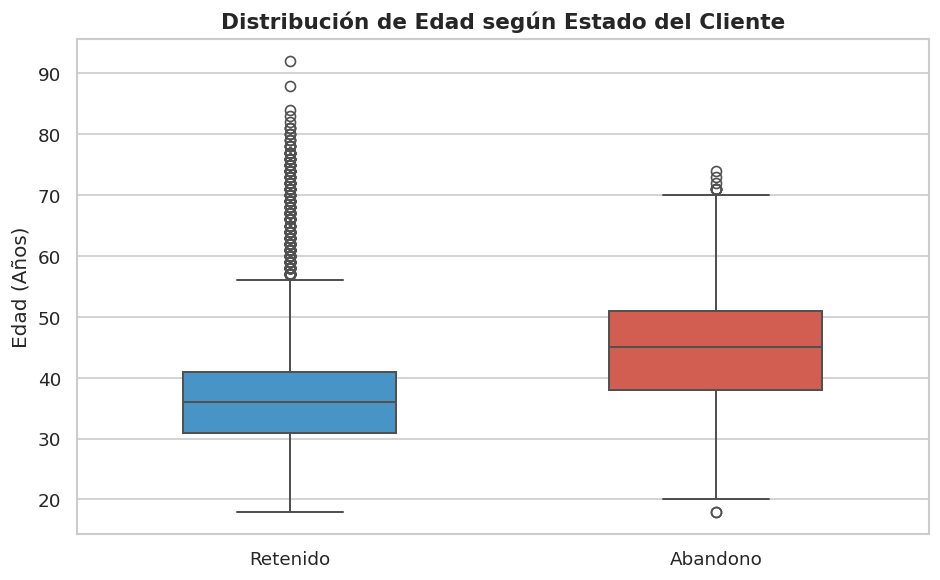

In [ ]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df_plot,
    x='Status',
    y='Age',
    palette=custom_palette,
    width=0.5,
    linewidth=1.2
)

plt.title('Distribución de Edad según Estado del Cliente', fontsize=13, fontweight='bold')
plt.xlabel('') 
plt.ylabel('Edad (Años)')

save_path = os.path.join(output_dir, '01_boxplot_age.png')
plt.tight_layout()
plt.savefig(save_path)
print(f"Gráfico guardado en: {save_path}")
plt.show()

#### Churn per Country

Gráfico guardado en: ../docs/images/02_barplot_geography.png


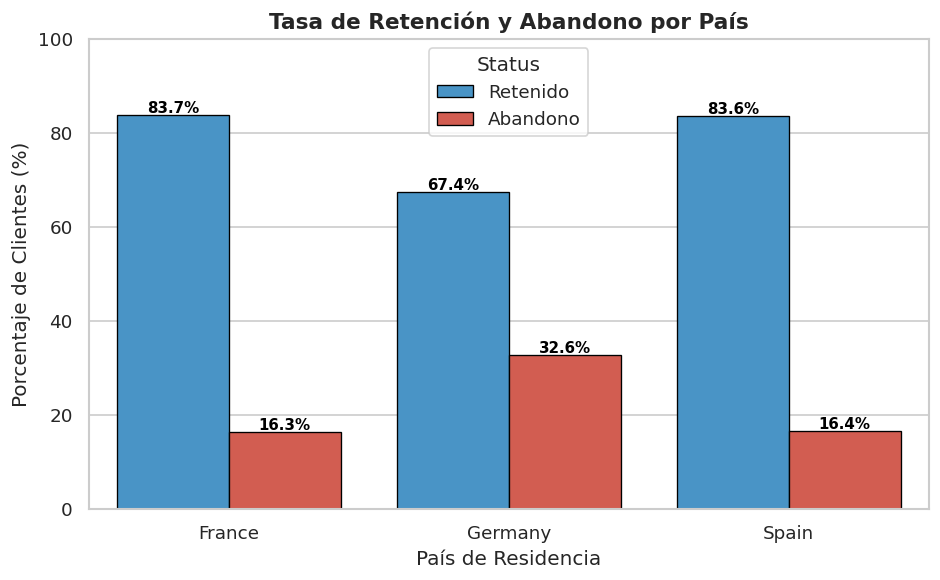

In [27]:
country_churn = df_plot.groupby('Geography')['Exited'].value_counts(normalize=True).mul(100).rename('Porcentaje').reset_index()
country_churn['Status'] = country_churn['Exited'].map({0: 'Retenido', 1: 'Abandono'})

plt.figure(figsize=(8, 5))

ax = sns.barplot(
    data=country_churn,
    x='Geography',
    y='Porcentaje',
    hue='Status',
    palette=custom_palette,
    edgecolor='black',
    linewidth=0.8
)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, color='black', fontweight='bold')

plt.title('Tasa de Retención y Abandono por País', fontsize=13, fontweight='bold')
plt.ylabel('Porcentaje de Clientes (%)')
plt.xlabel('País de Residencia')
plt.ylim(0, 100)

save_path = os.path.join(output_dir, '02_barplot_geography.png')
plt.tight_layout()
plt.savefig(save_path)
print(f"Gráfico guardado en: {save_path}")
plt.show()

### Multivariate Analysis

Gráfico guardado en: ../docs/images/05_multivariate_heatmap.png


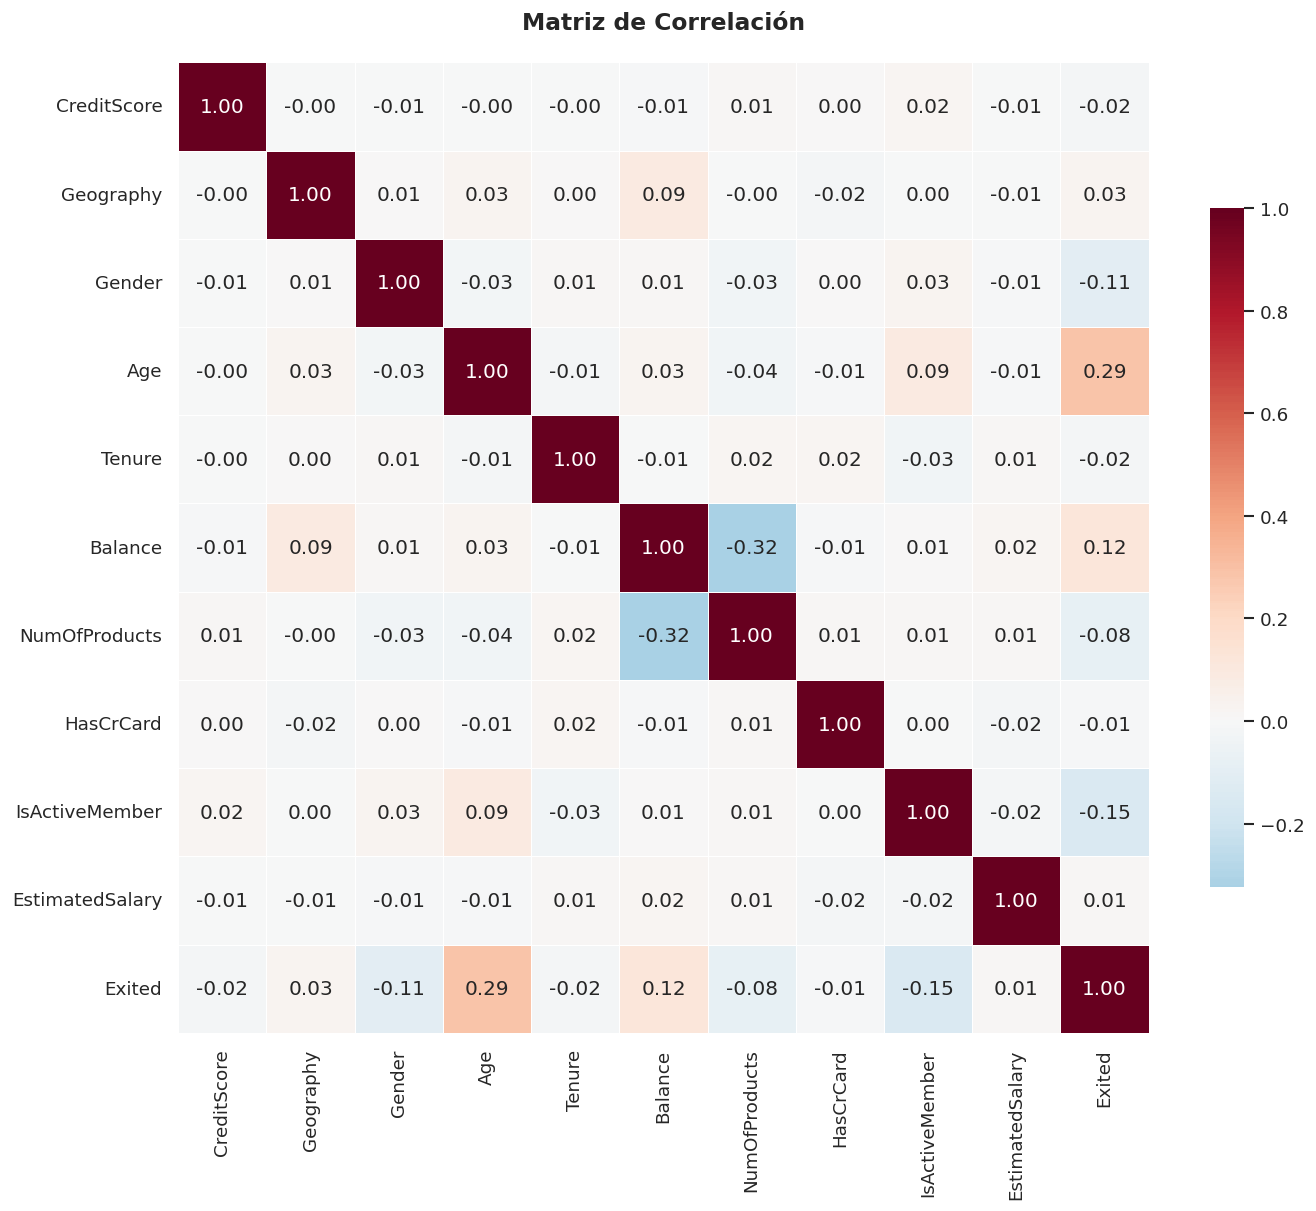

In [44]:
plt.figure(figsize=(12, 10))

df_multi = train_df.copy()

cols_to_drop = ['CustomerId', 'Surname']
df_multi = df_multi.drop(columns=[c for c in cols_to_drop if c in df_multi.columns])

for col in df_multi.select_dtypes(include=['object', 'category']).columns:
    df_multi[col] = df_multi[col].astype('category').cat.codes

corr_matrix = df_multi.corr(method='pearson')
corr_matrix = corr_matrix.loc[df_multi.columns, df_multi.columns]


sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .7}
)

plt.title('Matriz de Correlación', fontsize=14, fontweight='bold', pad=20)
plt.yticks(rotation=0)

plt.tight_layout()
save_path = os.path.join(output_dir, '05_multivariate_heatmap.png')
plt.savefig(save_path)
print(f"Gráfico guardado en: {save_path}")
plt.show()

### Numeric distributions and outliers

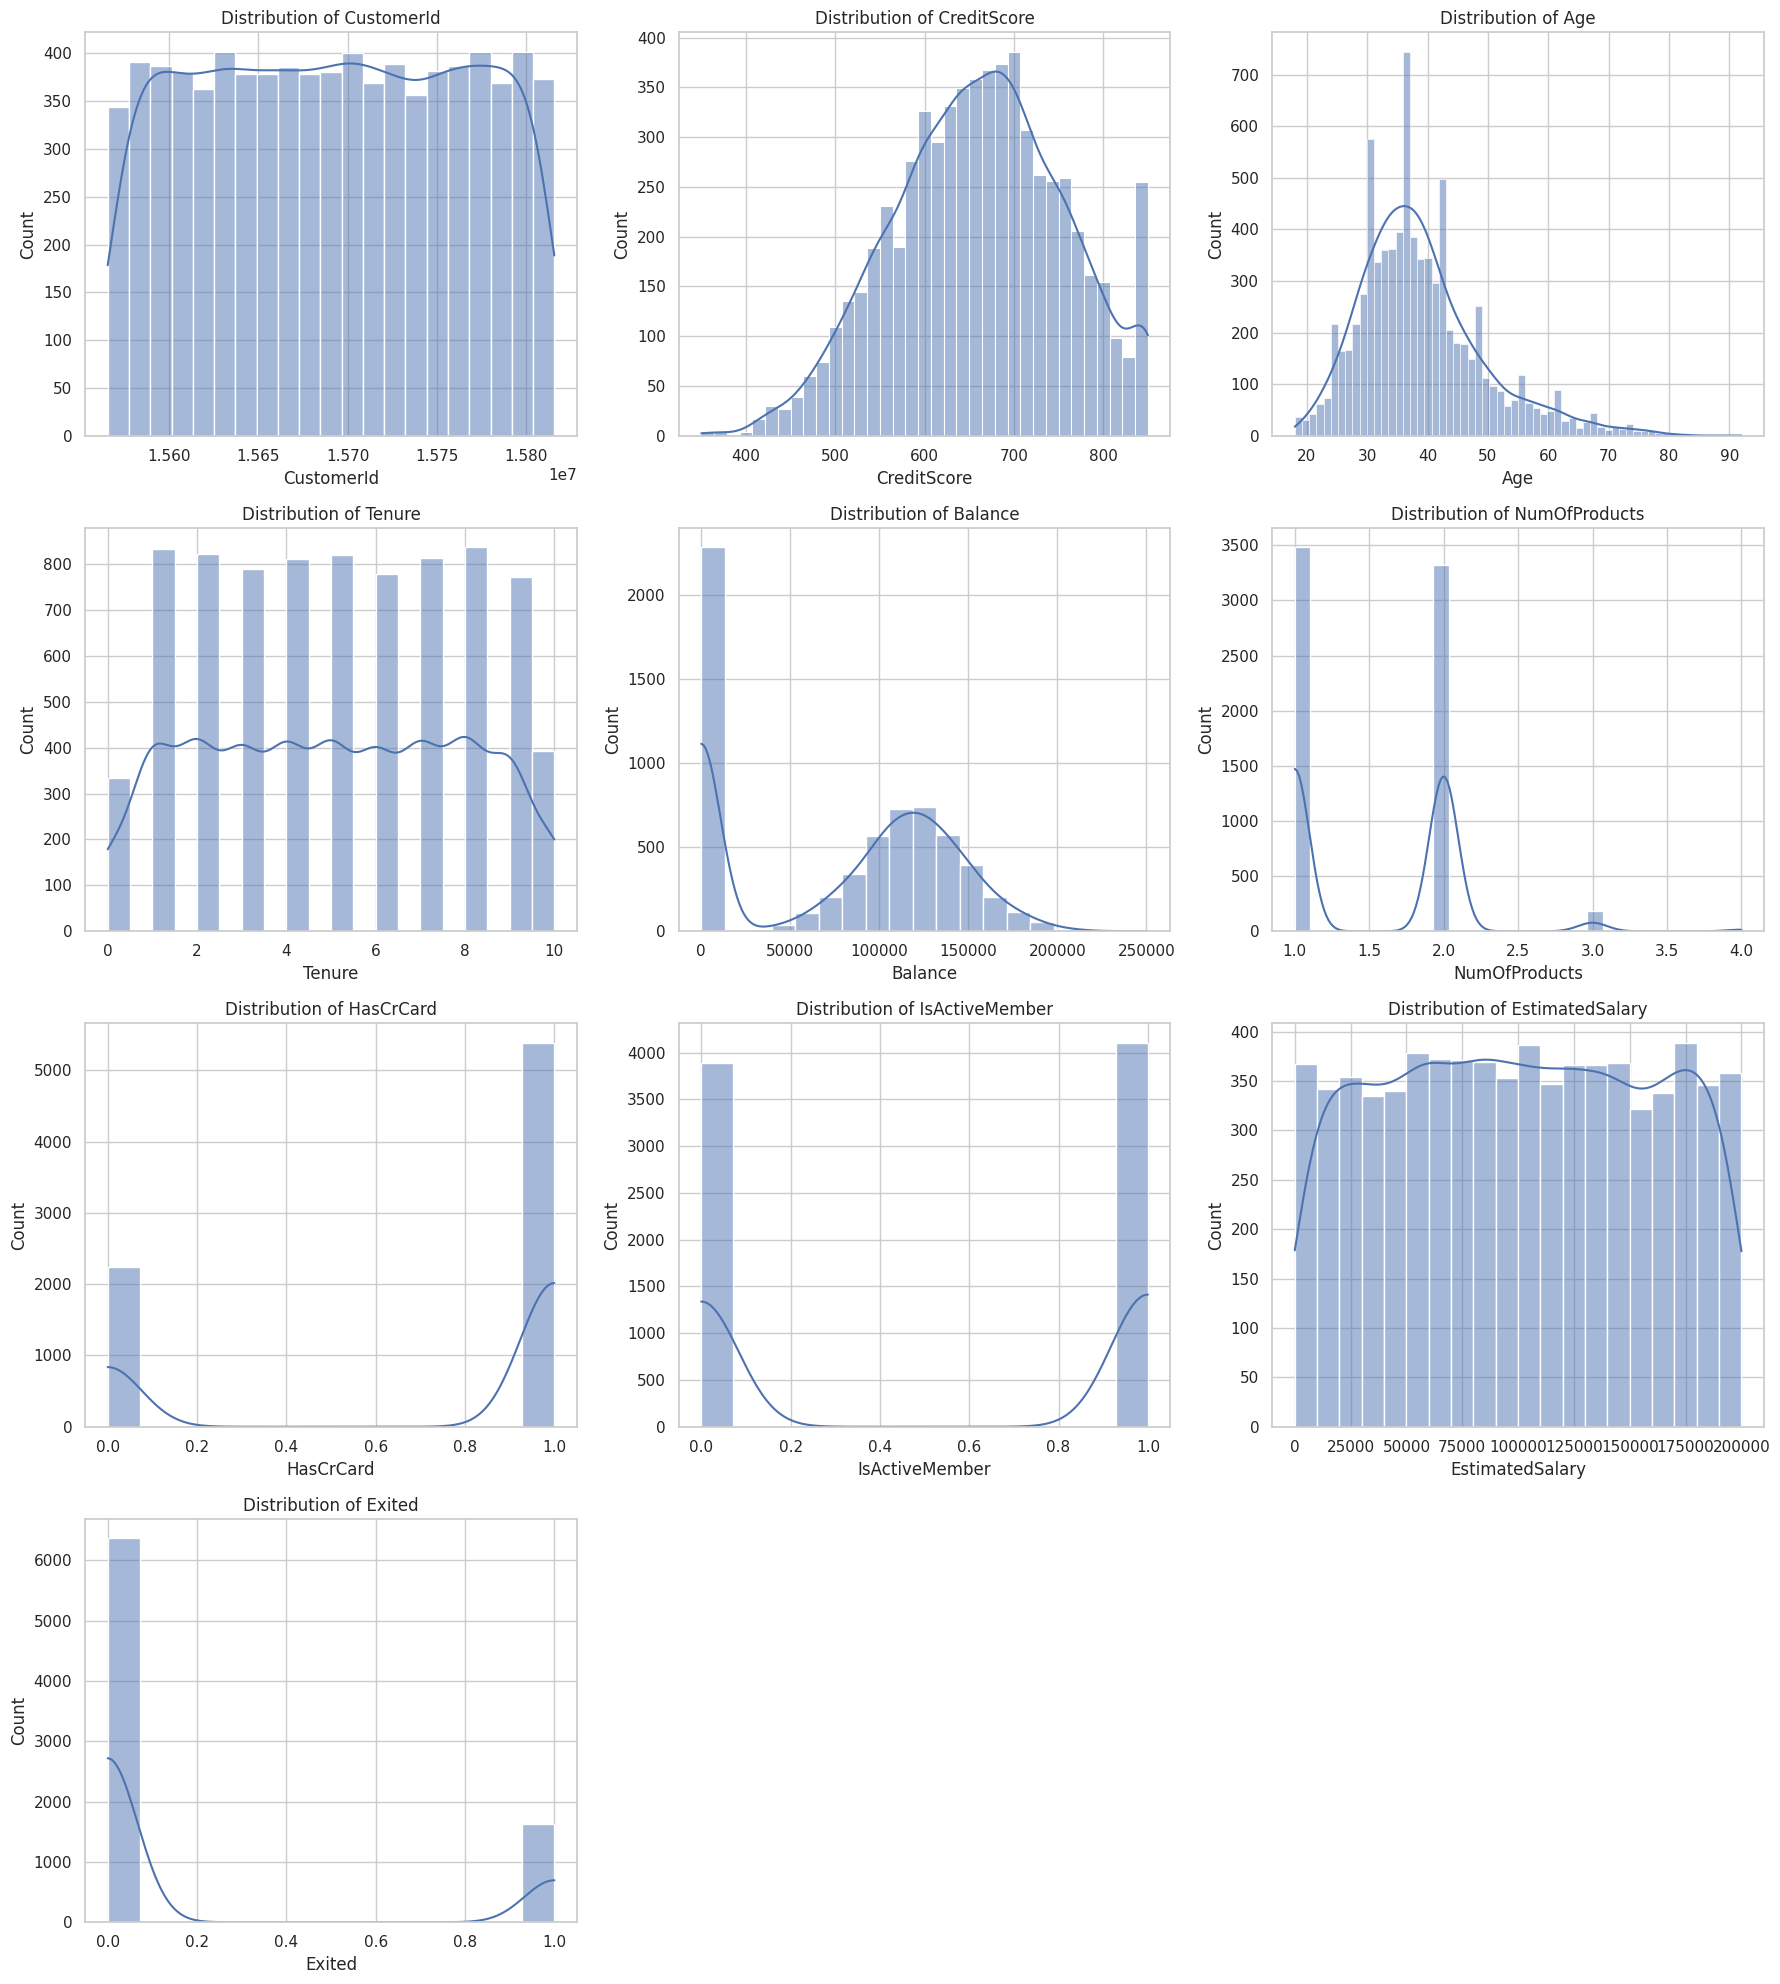

In [19]:
numeric_cols = train_df.select_dtypes(include="number").columns.tolist()

fig, axes = plt.subplots(len(numeric_cols) // 3 + 1, 3, figsize=(18, 5 * (len(numeric_cols) // 3 + 1)))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(train_df[col].dropna(), kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

total_plots = len(axes)
for ax in axes[len(numeric_cols):total_plots]:
    ax.axis("off")

plt.tight_layout()
plt.show()


**Observations on Numeric Distributions:**

- **Age** and **CreditScore** appear to have a somewhat normal distribution.
- **Balance** has a large number of zero values, which likely corresponds to customers with no balance. This could be a meaningful feature if treated as a separate category.
- **EstimatedSalary** has a uniform distribution, which is unusual and might suggest it's synthetic or randomly generated data.

### Feature relationships with target

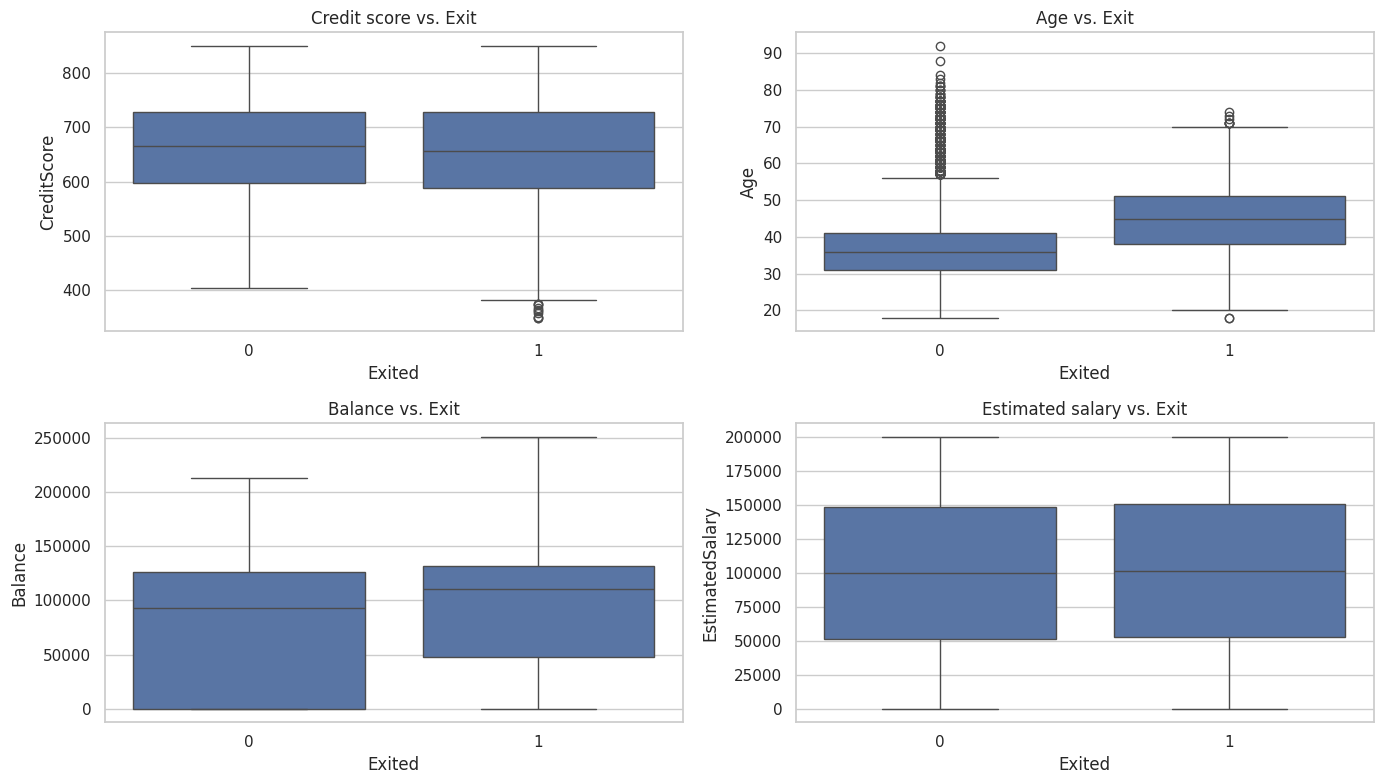

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.boxplot(data=train_df, x="Exited", y="CreditScore", ax=axes[0])
axes[0].set_title("Credit score vs. Exit")

sns.boxplot(data=train_df, x="Exited", y="Age", ax=axes[1])
axes[1].set_title("Age vs. Exit")

sns.boxplot(data=train_df, x="Exited", y="Balance", ax=axes[2])
axes[2].set_title("Balance vs. Exit")

sns.boxplot(data=train_df, x="Exited", y="EstimatedSalary", ax=axes[3])
axes[3].set_title("Estimated salary vs. Exit")

plt.tight_layout()
plt.show()


**Observations on Feature Relationships with Target:**

- **Age**: Customers who churned seem to be slightly older on average.
- **Balance**: Customers with a balance are more likely to churn than those with a zero balance.
- **CreditScore** and **EstimatedSalary** don't show a clear difference between churned and non-churned customers in these boxplots.

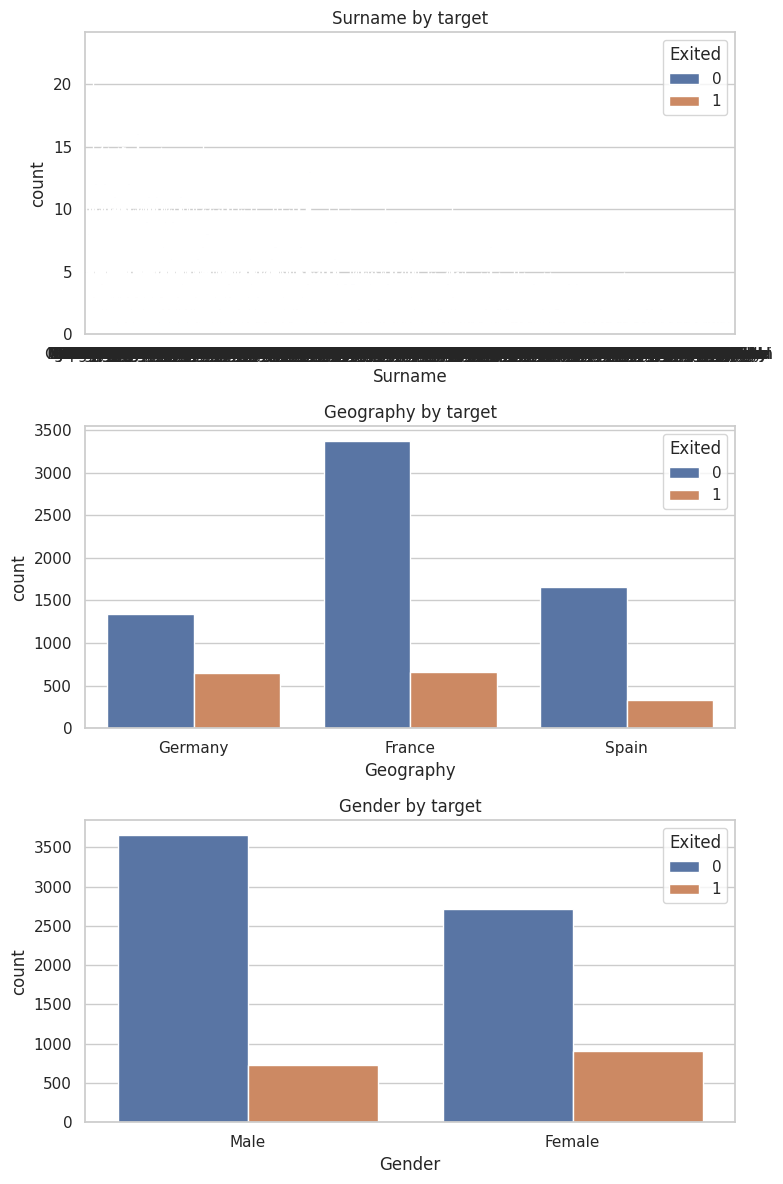

In [21]:
categorical_cols = train_df.select_dtypes(include="object").columns.tolist()
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(8, 4 * len(categorical_cols)))
if len(categorical_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, categorical_cols):
    sns.countplot(data=train_df, x=col, hue="Exited", ax=ax)
    ax.set_title(f"{col} by target")
    ax.legend(title="Exited", loc="upper right")

plt.tight_layout()
plt.show()


**Observations on Categorical Features:**

- **Geography**: Customers from Germany seem to have a higher churn rate compared to France and Spain.
- **Gender**: Female customers appear to have a slightly higher churn rate.

### Multivariate Analysis

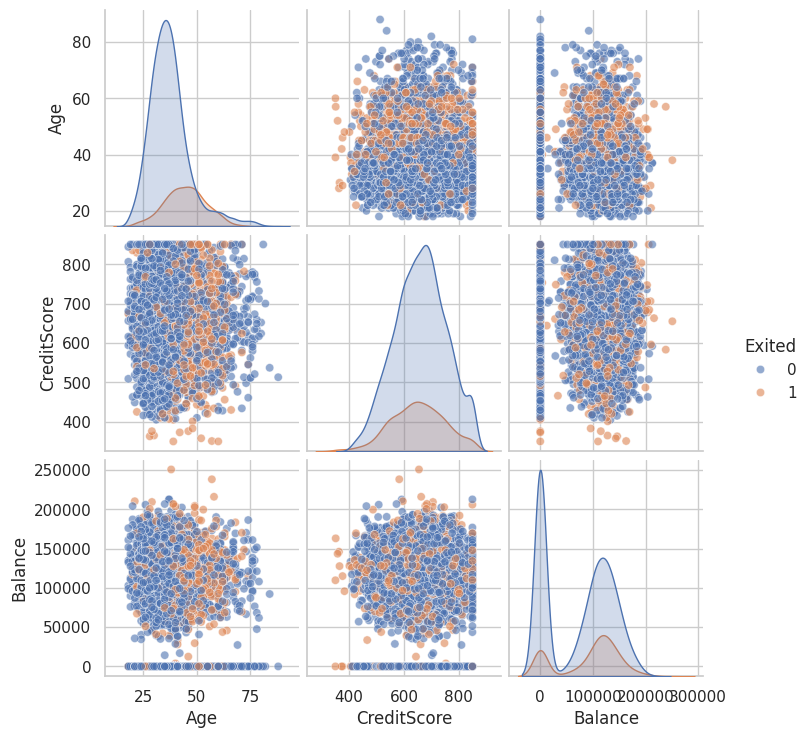

In [22]:
sns.pairplot(train_df[['Age', 'CreditScore', 'Balance', 'Exited']].dropna(), hue='Exited', plot_kws={'alpha': 0.6});
plt.show();

**Observations from Multivariate Analysis:**

- The pairplot helps to visualize interactions. For example, we can see the relationship between `Age` and `Balance` for both churned and non-churned customers.
- There are no strong linear relationships between the numeric features, but the separation by `Exited` is visible in some of the plots, confirming our earlier findings.